# Load Line P CTD casts
Author: Hayley Dosser
Created: October, 2025

Load and do some simple processing on CTD casts/profiles that were collected as part of the DFO Line P cruise program, then extracted from waterproperties.ca by Amber Holdsworth and made available via https://hpfx.collab.science.gc.ca/dfo/SD-Ocean/Training/observations/binned/. 

In [32]:
import datetime
import gsw
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pathlib
import xarray as xr

## User-specified parameters

In [33]:
path = 'C:/Users/DosserH/Documents/S2D/Statistical downscaling/HackathonLineP/LineP_CTD/'

## Load all CTD data into a Pandas dataframe

In [34]:
# Load the Line P CTD data one file at a time, extract the subset we want, and move it into timeseries for each depth and station
ctd_years = np.arange(1969,2021,1)

df_list = []
for i, n in enumerate(ctd_years):
    # load the file for each year
    df_temp = pd.read_csv(f'{path}/LineP_ctds_{ctd_years[i]}_binned_1m.csv',delimiter=',') 

    # remove data from P1 to P3 (the coastal stations)
    drop_condition = (df_temp['closest_linep_station_name']=='P1') | (df_temp['closest_linep_station_name']=='P2') | (df_temp['closest_linep_station_name']=='P3') 
    df_temp = df_temp.drop(df_temp[drop_condition].index)

    # remove data further than 500m away from a Line P station (optional)
    drop_condition = df_temp['distance_to_closest_station_km']>.5
    df_temp = df_temp.drop(df_temp[drop_condition].index)

    #add the dataframe into the list of dataframes
    df_list.append(df_temp)

#combine all the CTD casts into a single dataframe
df = pd.concat(df_list)

## Take a look at the CTD data

In [35]:
df

,time,file,CTDPRS_DBAR,CTDTMP_ITS90_DEG_C,SALINITY_PSS78,latitude,longitude,OXYGEN_MMOL_M3,OXYGEN_UMOL_KG,closest_linep_station_name,distance_to_closest_station_km,PRS_bin_cntr
101,1996-08-22 23:49:41.930,MP17_CastCTD_1996-08-22_2349h.nc,1.0,14.8395,32.5366,49.348331,-135.670837,NaN,NaN,P17,0.352484,1.5
102,1996-08-22 23:49:41.930,MP17_CastCTD_1996-08-22_2349h.nc,2.0,14.8395,32.5365,49.348331,-135.670837,NaN,NaN,P17,0.352484,2.5
103,1996-08-22 23:49:41.930,MP17_CastCTD_1996-08-22_2349h.nc,2.9,14.8395,32.5370,49.348331,-135.670837,NaN,NaN,P17,0.352484,2.5
104,1996-08-22 23:49:41.930,MP17_CastCTD_1996-08-22_2349h.nc,4.0,14.8382,32.5369,49.348331,-135.670837,NaN,NaN,P17,0.352484,4.5
105,1996-08-22 23:49:41.930,MP17_CastCTD_1996-08-22_2349h.nc,5.1,14.8370,32.5374,49.348331,-135.670837,NaN,NaN,P17,0.352484,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...
147009,2020-02-13 12:39:40,P17_CastCTD_2020-02-13_1239h.nc,2001.0,1.9819,34.5800,49.350166,-135.666840,53.52,52.0,P17,0.021078,2001.5
147010,2020-02-13 12:39:40,P17_CastCTD_2020-02-13_1239h.nc,2002.0,1.9802,34.5804,49.350166,-135.666840,53.52,52.0,P17,0.021078,2002.5
147011,2020-02-13 12:39:40,P17_CastCTD_2020-02-13_1239h.nc,2003.0,1.9801,34.5804,49.350166,-135.666840,53.52,52.0,P17,0.021078,2003.5
147012,2020-02-13 12:39:40,P17_CastCTD_2020-02-13_1239h.nc,2004.0,1.9800,34.5805,49.350166,-135.666840,53.52,52.0,P17,0.021078,2004.5


## Calculate new variables of interest and add them to the data frame
Plus rename some variables for simplicity

In [ ]:
# Create a new variable with the date in a format we can work with
to_datetime = lambda x: datetime.datetime.strptime(x[:19], '%Y-%m-%d %H:%M:%S')
df['TIME'] = df['time'].apply(to_datetime)

# Move from pressure to depth levels
fld = -gsw.z_from_p(df.CTDPRS_DBAR,df.latitude)
df['DEPTH'] = fld

# Remove questionable salinity value(s)
drop_salinity = df['SALINITY_PSS78']<25
df = df.drop(df[drop_salinity].index)

# Rename variables
df = df.rename(columns={"latitude": "LATITUDE"})
df = df.rename(columns={"longitude": "LONGITUDE"})
df = df.rename(columns={"CTDPRS_DBAR": "PRESSURE"})
df = df.rename(columns={"CTDTMP_ITS90_DEG_C": "TEMPERATURE"})
df = df.rename(columns={"SALINITY_PSS78": "SALINITY"})
df = df.rename(columns={"OXYGEN_UMOL_KG": "OXYGEN"})
df = df.rename(columns={"closest_linep_station_name": "STATION_ID"})

### Quick look at the distribution for each variable

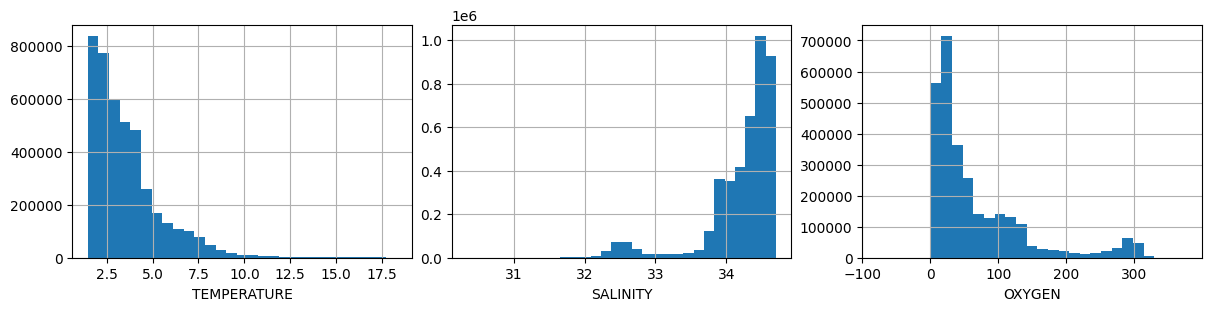

In [37]:
var_list = ['TEMPERATURE','SALINITY','OXYGEN']
fig, ax = plt.subplots(1, ncols=3, constrained_layout=True, figsize=(12, 3))

for n, var in enumerate(var_list):
    fld = df[var].values   

    bins = np.arange(np.nanmin(fld),np.nanmax(fld),(np.nanmax(fld)-np.nanmin(fld))/30)
    ax[n].hist(fld,bins,alpha=1)
    ax[n].set_xlabel(var)
    ax[n].grid()

In [38]:
df

,time,file,PRESSURE,TEMPERATURE,SALINITY,latitude,longitude,OXYGEN_MMOL_M3,OXYGEN,STATION_ID,distance_to_closest_station_km,PRS_bin_cntr,TIME,DEPTH
101,1996-08-22 23:49:41.930,MP17_CastCTD_1996-08-22_2349h.nc,1.0,14.8395,32.5366,49.348331,-135.670837,NaN,NaN,P17,0.352484,1.5,1996-08-22 23:49:41,0.991485
102,1996-08-22 23:49:41.930,MP17_CastCTD_1996-08-22_2349h.nc,2.0,14.8395,32.5365,49.348331,-135.670837,NaN,NaN,P17,0.352484,2.5,1996-08-22 23:49:41,1.982966
103,1996-08-22 23:49:41.930,MP17_CastCTD_1996-08-22_2349h.nc,2.9,14.8395,32.5370,49.348331,-135.670837,NaN,NaN,P17,0.352484,2.5,1996-08-22 23:49:41,2.875294
104,1996-08-22 23:49:41.930,MP17_CastCTD_1996-08-22_2349h.nc,4.0,14.8382,32.5369,49.348331,-135.670837,NaN,NaN,P17,0.352484,4.5,1996-08-22 23:49:41,3.965912
105,1996-08-22 23:49:41.930,MP17_CastCTD_1996-08-22_2349h.nc,5.1,14.8370,32.5374,49.348331,-135.670837,NaN,NaN,P17,0.352484,5.5,1996-08-22 23:49:41,5.056524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147009,2020-02-13 12:39:40,P17_CastCTD_2020-02-13_1239h.nc,2001.0,1.9819,34.5800,49.350166,-135.666840,53.52,52.0,P17,0.021078,2001.5,2020-02-13 12:39:40,1974.521684
147010,2020-02-13 12:39:40,P17_CastCTD_2020-02-13_1239h.nc,2002.0,1.9802,34.5804,49.350166,-135.666840,53.52,52.0,P17,0.021078,2002.5,2020-02-13 12:39:40,1975.503826
147011,2020-02-13 12:39:40,P17_CastCTD_2020-02-13_1239h.nc,2003.0,1.9801,34.5804,49.350166,-135.666840,53.52,52.0,P17,0.021078,2003.5,2020-02-13 12:39:40,1976.485963
147012,2020-02-13 12:39:40,P17_CastCTD_2020-02-13_1239h.nc,2004.0,1.9800,34.5805,49.350166,-135.666840,53.52,52.0,P17,0.021078,2004.5,2020-02-13 12:39:40,1977.468096


## Write pre-processed data to CSV

In [39]:
# Text for the CSV file header
header_text = """
# Description: CTD casts/profiles collected as part of the DFO Line P cruise program 
# then extracted from waterproperties.ca by Amber Holdsworth, made available via 
# https://hpfx.collab.science.gc.ca/dfo/SD-Ocean/Training/observations/binned/, 
# and pre-processed for the SD-Ocean Line P Hackathon in October 2025. 
# Temperature, salinity, and oxygen are collected using sensors lowered through the 
# water column at or near Line P stations.  
# 
# Coordinates:
# STATION_ID for Line P stations P4 to P26
# TIME in UTC between 1969 to 2020 
# LATITUDE in decimal degrees
# LONGITUDE in decimal degrees
# DEPTH in m
# PRESSURE in dbar
# 
# Variables: 
# TEMPERATURE in degrees Celcius (in-situ)
# SALINITY PSS-78
# OXYGEN in µmol/kg (dissolved oxygen)

"""

In [41]:
# Write the variables to CSV
variable_list = [
    'STATION_ID',
    'TIME',
    'LATITUDE',
    'LONGITUDE',
    'DEPTH',
    'PRESSURE',
    'TEMPERATURE',
    'SALINITY',
    'OXYGEN'
]

with open("DFO_LineP_CTDdata.csv","w") as f:
    f.write(header_text)
    df[variable_list].to_csv(f,index=False,na_rep="NaN")